# Insert Libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

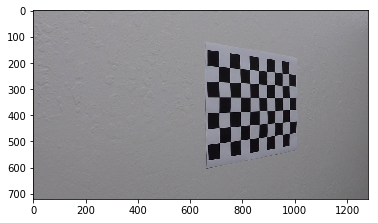

In [2]:
rand = np.random.randint(1,20)
test_calib_image = mpimg.imread('camera_cal/calibration'+str(rand)+'.jpg')
image_shape = (test_calib_image.shape[0], test_calib_image.shape[1])
plt.imshow(test_calib_image)

As we see, we have 6 edge points in a column and 9 edge points in a row

In [3]:
nx = 9
ny = 6
#Define object Points
objp = np.zeros((nx*ny,3), np.float32)
objp[:, :2] = np.mgrid[0:nx,  0:ny].T.reshape(-1,2)

objpoints = [] #3d Real objects 
imgpoints = [] #2d image plane

# List of images
images = glob.glob('camera_cal/calibration*.jpg')

for name in images:
    img = cv2.imread(name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)

# After calculating camera calibration matrix we can undistort our images

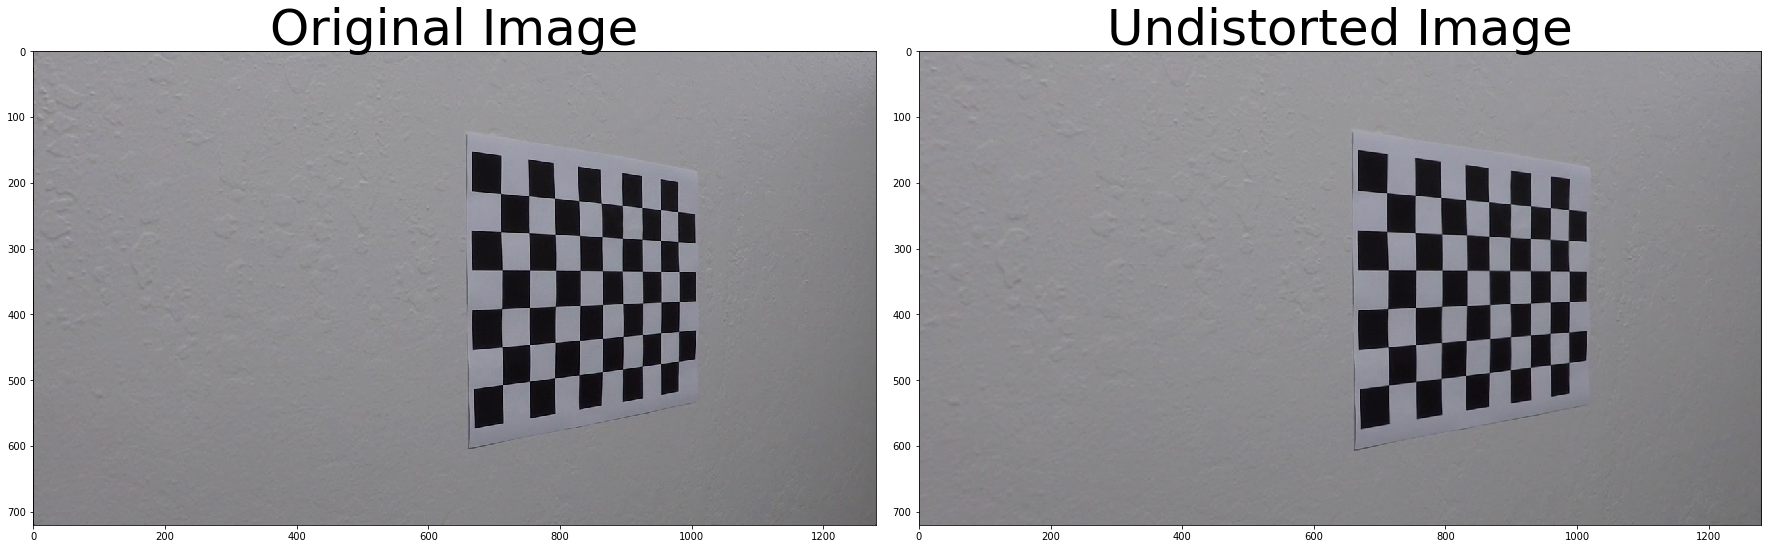

In [4]:
dst = cv2.undistort(test_calib_image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_calib_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

# After undistorting the image we can now start aplying, treshold, transform, gradient techniques to get binary output image

In [5]:
def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = (0,255)):
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
        
    scaled_sobel = np.uint8(255 * abs_sobel/ np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel = 3, mag_thresh = (0,255)):
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    gradMag = np.sqrt(sobelX ** 2 + sobelY ** 2)
    
    gradMag = np.uint8((gradMag / (np.max(gradMag)/ 255)))
    
    binary_output = np.zeros_like(gradMag)
    binary_output[(gradMag >= mag_thresh [0]) & (gradMag <= mag_thresh[1])] = 1
    
    return binary_output 

def dir_threshold(img, sobel_kernel = 3, thresh = (0, np.pi//2)):
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    absX = np.absolute(sobelX)
    absY = np.absolute(sobelY)
    
    absgrdaddir = np.arctan2(absY, absX)
    
    binary_out = np.zeros_like(absgrdaddir)
    binary_out[(absgrdaddir >= thresh[0]) & (absgrdaddir < thresh[1])] = 1
    return binary_out

def gradient_threshold(img):
    # We undistort image and then we convert our image into HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    #Then we take S channel as it is considered as best in detecting lane lines
    s_channel = hls[:,:,2]
    #Aftere that we apply functions defined above to apply threshold to our image
    
    #Firstly we apply gradient threshold
    ksize = 3
    gradX = abs_sobel_thresh(s_channel, orient = 'x', thresh = (20,100))
    gradY = abs_sobel_thresh(s_channel, orient = 'y', thresh = (20,100))
    # Then we have magnitude and direction threshold
    mag_binary = mag_thresh(s_channel, sobel_kernel = ksize, mag_thresh = (30,100))
    dir_binary = dir_threshold(s_channel, sobel_kernel = ksize, thresh = (0.7, 1.3))
    
    # We combine all of them
    combined_img = np.zeros_like(dir_binary)
    combined_img[((gradX == 1) & (gradY == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined_img

def binary_threshold(img):
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Defining threshold of the color channels used
    s_threshold_min = 160
    s_threshold_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_threshold_min) & (s_channel <= s_threshold_max)] = 1
    
    b_threshold_min = 150
    b_threshold_max = 255
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_threshold_min) & (b_channel <= b_threshold_max)] = 1
    
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (b_binary == 1)] = 1
    
    return combined_binary

def combined(img):
    
    threshold_img = binary_threshold(img)
    gradient_img = gradient_threshold(img)
    
    combined = np.zeros_like(gradient_img)
    combined[(gradient_img == 1) | (threshold_img == 1)] = 1
    
    return combined

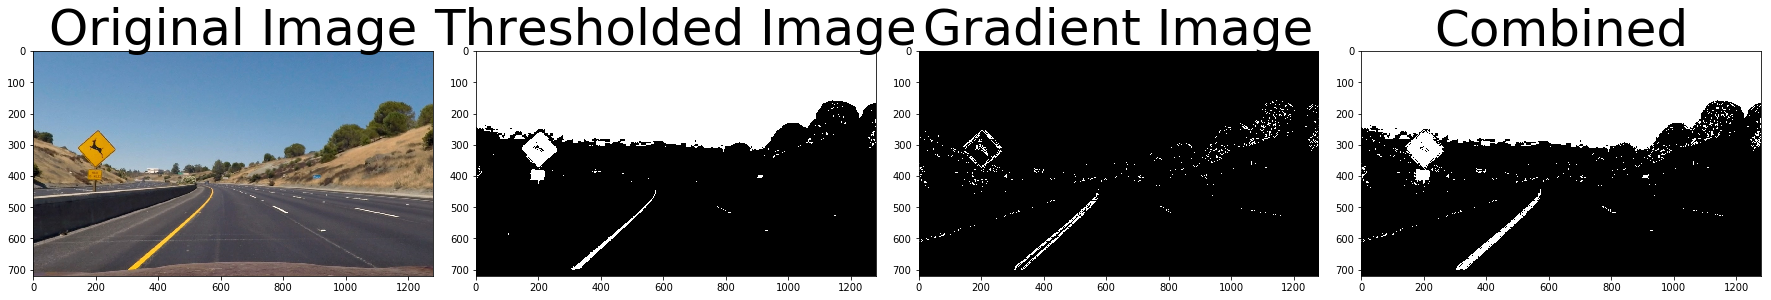

In [6]:
test_image = mpimg.imread('test_images/test2.jpg')
test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
thresholded = binary_threshold(test_image)
gradient_img = gradient_threshold(test_image)
combined_img = combined(test_image)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image, cmap = 'gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap = 'gray')
ax2.set_title('Thresholded Image', fontsize=50)
ax3.imshow(gradient_img, cmap = 'gray')
ax3.set_title('Gradient Image', fontsize=50)
ax4.imshow(combined_img, cmap = 'gray')
ax4.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

# Perspective Transform 

In [7]:
def corners_unwarp(img):
    # First we define source and destination points
    bottom_L = ([190, 720], [320, 720])
    bottom_R = ([1180, 720],[920, 720])
    top_L = ([550, 470], [320, 1])
    top_R = ([750, 470], [920, 1])
    
    src = np.float32([bottom_L[0],bottom_R[0],top_R[0],top_L[0]])
    dst = np.float32([bottom_L[1],bottom_R[1],top_R[1],top_L[1]])
    
    img_size = (img.shape[1], img.shape[0])
    #Then we apply perspectinve transformation to get birds eye
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped,M, Minv


We can check out lines

Text(0.5,1,'Chosen lines')

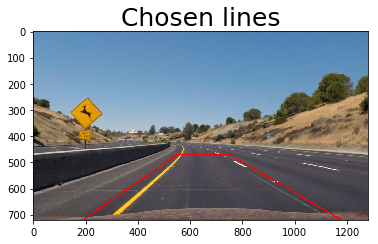

In [8]:
bottom_left = ([190, 720])
bottom_right = ([1180, 720])
top_left = ([550, 470])
top_right = ([750, 470])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = test_image.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

plt.imshow(copy)
plt.title('Chosen lines', fontsize=25)

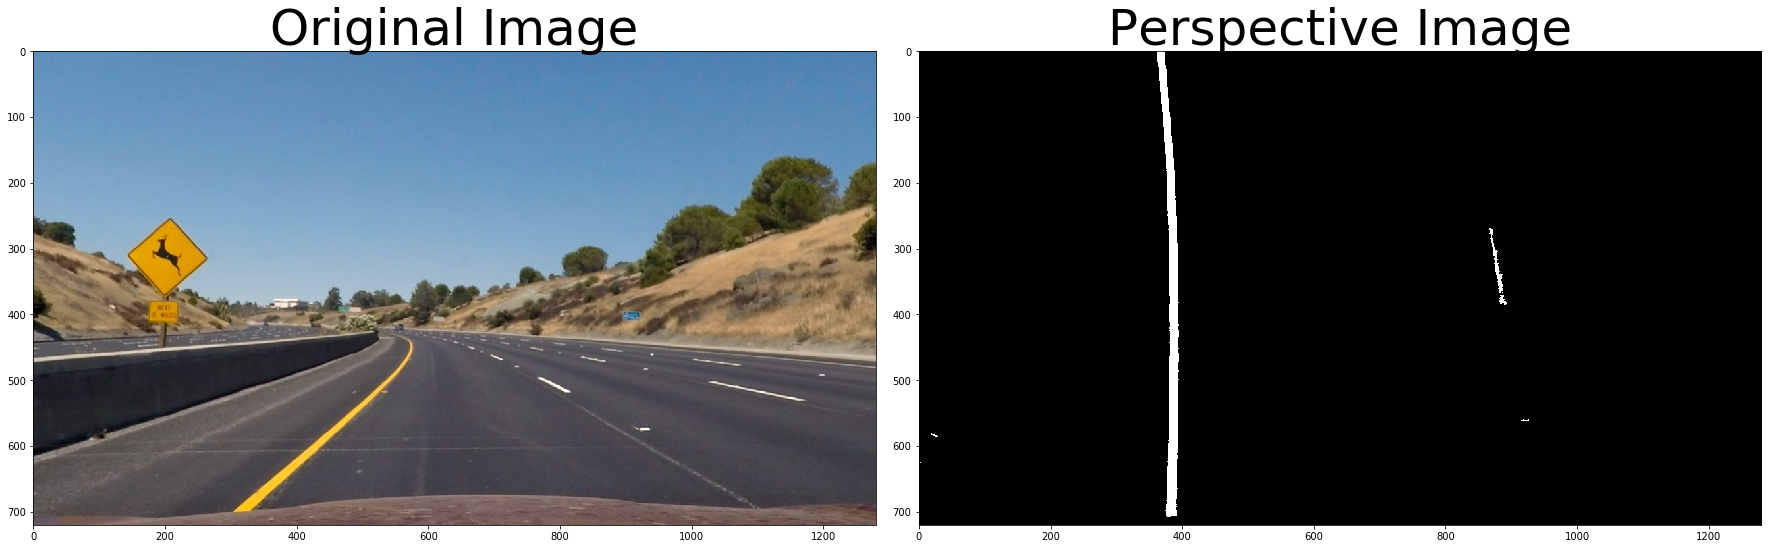

In [9]:
#thresholded bird-eye image
bird_eye,M, Minv = corners_unwarp(test_image)
warped,M, Minv = corners_unwarp(test_image)
bird_eye = binary_threshold(bird_eye)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image, cmap = 'gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(bird_eye, cmap = 'gray')
ax2.set_title('Perspective Image', fontsize=50)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

# Now its time to make some histograms

Left Peak: 381
Right Peak: 882


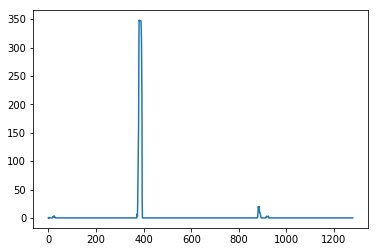

In [10]:
histogram = np.sum(bird_eye[bird_eye.shape[0]//2:,:], axis=0)
plt.plot(histogram)

#We can also output the peaks of leaft and right parts
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print("Left Peak: %s" % leftx_base)
print("Right Peak: %s" % rightx_base)

# Now we can detect lines 

In [11]:
def detect_lanes(img, left_peak, right_peak, nwindows = 9):
    # nwindows is the number of sliding windows 
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = left_peak
    rightx_current = right_peak
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    rectangles = []
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        rectangles.append((win_y_low,win_y_high,win_xleft_low,win_xleft_high,win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_fit, right_fit = (None, None)
    radius = 0
    center_dist = 0
    
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    if len(leftx) > 0 and len(rightx) > 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        #Using these values we can calculate curvature 

        ym_per_pix = 30./720 # meters per pixel in y dimension
        
        y_eval = np.max(lefty)
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                        /np.absolute(2*right_fit_cr[0])

        radius = (left_curverad + right_curverad)//2

    #We can calculate Center here
    if left_fit is not None and right_fit is not None:
        car_position = img.shape[1]//2
        height = img.shape[0]
        left_fit_x = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
        righ_fit_x = right_fit[0]*height**2 + right_fit[1]*height+ right_fit[2]
        center_position = (left_fit_x + righ_fit_x) / 2
        center_dist = (car_position - center_position) * xm_per_pix
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles, radius, center_dist

Now we are ready to visualize results


(720, 1280, 3)


(720, 0)

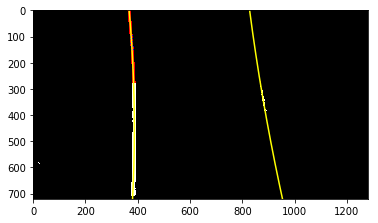

In [12]:
out_img = np.dstack((bird_eye, bird_eye, bird_eye))*255

left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles, radius, center_dist = detect_lanes(bird_eye, 
                                                                                                     leftx_base, 
                                                                                                     rightx_base)

# Generate x and y values for plotting
ploty = np.linspace(0, bird_eye.shape[0]-1, bird_eye.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print(out_img.shape)
"""

for rectangle in rectangles:
# Draw the windows on the visualization image
    print(rectangle[0],rectangle[1],rectangle[2],rectangle[3],rectangle[4], rectangle[5])
    cv2.rectangle(out_img,(rectangle[2],rectangle[0]),(rectangle[3],rectangle[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rectangle[4],rectangle[0]),(rectangle[5],rectangle[1]),(0,255,0), 2)

"""

nonzeroP = out_img.nonzero()
nonzeroy = np.array(nonzeroP[0])
nonzerox = np.array(nonzeroP[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img,cmap = 'gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Detecting lines for every next step

In [13]:
# To do that we have our base points we only define margin and repeat same steps
def next_step_lines(img, left_fit, right_fit, margin = 100):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, bird_eye.shape[0]-1, bird_eye.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    if len(leftx) > 0 and len(rightx) > 0:
        y_eval = np.max(lefty)
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                        /np.absolute(2*right_fit_cr[0])

        radius = (left_curverad + right_curverad)//2

    #We can calculate Center here
    if len(left_fit) > 0 and len(right_fit) > 0:
        car_position = img.shape[1]//2
        height = img.shape[0]
        left_fit_x = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
        righ_fit_x = right_fit[0]*height**2 + right_fit[1]*height+ right_fit[2]
        center_position = (left_fit_x + righ_fit_x) / 2
        center_dist = (car_position - center_position) * xm_per_pix
        
    return left_lane_inds, right_lane_inds, left_fitx, right_fitx, radius, center_dist

We can now visualize the results

(720, 0)

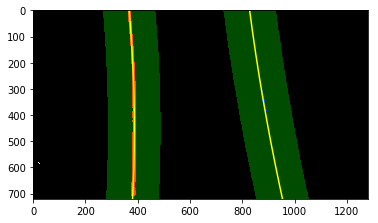

In [14]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((bird_eye, bird_eye, bird_eye))*255
window_img = np.zeros_like(out_img)

margin = 100
nonzero = bird_eye.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

left_lane_inds, right_lane_inds, left_fitx, right_fitx, radius, center_dist = next_step_lines(bird_eye, 
                                                                                              left_fit, 
                                                                                              right_fit)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Now it's time to paint our lane area

Text(200,175,'Radius of curvature is 2556m')

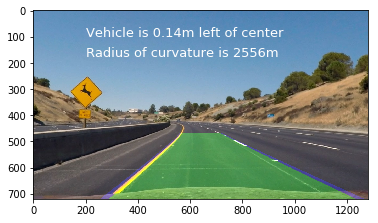

In [15]:
warp_zero = np.zeros_like(bird_eye).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

undist = cv2.undistort(test_image, mtx, dist, None, mtx)
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (test_image.shape[1], test_image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(test_image, 1, newwarp, 0.3, 0)
plt.imshow(result)
if center_dist < 0:
    plt.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(np.absolute(center_dist)),
             color='white', fontsize=13)
else:
    plt.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(np.absolute(center_dist)),
            color='white', fontsize=13)
plt.text(200, 175, 'Radius of curvature is {}m'.format(int(radius)),
            color='white', fontsize=13)

# Now it's time to calculate the curvature

In [16]:
def calculate_curvature():
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])

Now we can print out the value in real world picture (metres)

# Now we can combine everything together

In [18]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def fit_Check(self, fit, idx):
        # if fit is not None, we can add it to current one
        if fit is not None:
            #if best fit exists we compare our fit to it
            if self.best_fit is not None:
                self.diffs = np.abs(fit-self.best_fit) # we Check difference between fits
                if self.diffs[0] > 0.001 and len(self.currenct_fit)>0:
                    self.detected = False
                else:
                    #if everything seems ok we add fit to current fit
                    self.detected = True
                    self.current_fit.append(fit)
                    if len(self.current_fit) > 5:
                        # throw out old fits, keep newest n
                        self.current_fit = self.current_fit[len(self.current_fit)-5:]
                    #we also calculate best fit
                    self.best_fit = np.average(self.current_fit, axis = 0)
        else:
            self.detected = False
            # If our fit is none we have to go back to current fit
            self.current_fit = self.current_fit[:len(self.current_fit)-1]
        

# Here we define whole process of finding images and etc.

In [19]:
def process_img(img):
    #we perform prepocessing steps for our img
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    unwarped, M, Minv = corners_unwarp(undist)
    binary_img = combined(unwarped)
    
    # We find peaks now
    histogram_fit = np.sum(binary_img[binary_img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram_fit.shape[0]//2)
    leftx_base = np.argmax(histogram_fit[:midpoint])
    rightx_base = np.argmax(histogram_fit[midpoint:]) + midpoint
    
    if not left_line.detected or not right_line.detected:
        left_fit, right_fit, left_lane_indices, right_lane_indices, rectangles, radius, center_distance = detect_lanes(binary_img, 
                                                                                                     leftx_base, 
                                                                                                     rightx_base)
    else:
        left_fit, right_fit, left_lane_indices, right_lane_indices, rectangles, radius, center_distance = next_step_lines(binary_img, 
                                                                                                     left_line.best_fit, 
                                                                                                     right_line.best_fit)
        
    left_line.fit_Check(left_fit, left_lane_inds)
    right_line.fit_Check(right_fit, right_lane_inds)
    
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    undist = cv2.undistort(test_image, mtx, dist, None, mtx)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_DUPLEX
    if center_dist < 0:
        text = 'Vehicle is {:.2f}m left of center'.format(np.absolute(center_distance))
        cv2.putText(result, text, (400, 150), font, 1.5, (255,255,255), 2)
    else:
        text = 'Vehicle is {:.2f}m right of center'.format(np.absolute(center_distance))
        cv2.putText(result, text, (400, 150), font, 1.5, (255,255,255), 2)
    
    text = 'Radius of curvature is {}m'.format(int(radius))
    cv2.putText(result, text, (400, 250), font, 1.5, (255,255,255), 2)
    
    return result
    

In [20]:
from moviepy.editor import VideoFileClip
left_line = Line()
right_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_img)
%time processed_video.write_videofile(video_output1, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:20<00:00,  3.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 20s


In [21]:
# We can try it on challenge video as well
left_line = Line()
right_line = Line()

video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(22,26)
processed_video = video_input2.fl_image(process_img)
%time processed_video.write_videofile(video_output2, audio=False)


[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:59<00:00,  4.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 59s


In [22]:
# We can also check for harder challenge video

left_line = Line()
right_line = Line()

video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')#.subclip(22,26)
processed_video = video_input3.fl_image(process_img)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [07:14<00:00,  2.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 7min 16s


In [23]:
#We take 10 real images from video

left_line = Line()
right_line = Line()

vidcap = cv2.VideoCapture('project_video.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
    cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1
    if count == 10:
        success = False

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
